## Loan Default Prediction

### Project Description: 
In an era where peer-to-peer financing platforms have revolutionized investment opportunities, the LendingClub stands out as a key player, allowing investors to participate in consumer loans. This project aims to leverage machine learning techniques to predict default probabilities for loans on the LendingClub platform, empowering investors to make informed decisions and optimize their returns.

### Goals
- Develop basic understanding of risk anlytics in banking and financial sercice (credit risk accessment)
- Predict default probabilities for 2018 loans by training models on pre-2018 loan data
- Analyzes borrower's capability to repay by using machine learning and data analytics to help to reduce the default risk and therefore maximize the investment return. 


Techinqiue used here : Logistic Regression, Naive Bayes, and SVM classifiers

### Project Outline

- [1.Import data](#section1)
- [2.Data Preprocessing](#section2)
- [3.Data Analysis](#section3)
    - [3.1] Loan amount and installment
    - [3.2] Grades and subgrades
    - 



<!-- Feature Selection I: EDA

Feature Section II: (Linear) correlation between (numerical) features
5.1 Convert target variable to 0/1 indicator
5.2 K-S test
5.3 Pearson Correlation
Feature Engineering
6.1 Dummy variables
6.2 Train/Test data split
6.3 Imputing missing values
6.4 Feature Scaling
6.5 PCA visualization of the train data
6.6 Linear dependence of Charged-Off
Modeling
7.1 Logistic Regression with SGD
7.2 Random Forest
7.3 KNN
7.4 Hyperparameter tuning on the best model
7.5 Evaluate the best model on the testing set
Further understanding the model
Conclusion -->


In [1]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm 
import seaborn as sns
import itertools
import datetime
import random
import os, sys
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
cmap = plt.colormaps["tab20"]

In [2]:
####  stdout style   #####
import logging

logging.basicConfig(
    level=logging.INFO, 
    format='%(levelname)s - - - - - - - - %(message)s  - - - - - - - ',
    handlers=[
        logging.FileHandler(filename='tmp.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger('LOGGER_NAME')

In [23]:
##### helper functions
def convert_to_default_rate(df, factor):
    if not isinstance(factor, list):
        factor = [factor]
    gp = df.set_index('loan_status')[factor].stack(dropna=False
                                          ).groupby('loan_status', dropna=False
                                          ).value_counts(dropna=False
                                          ).unstack(fill_value=0).T
    gp['Default Rate'] = gp['Charged Off']/gp.sum(axis=1)*100
    return gp

def set_ax_param(ax, title=None, ylabel=None, xlabel=None, loc='upper right'):
    
    ax.set_title(title)
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
    if loc:
        ax.legend(loc=loc)
    return ax

<a id='section1'></a>
### 1 Data Preparation

#### 1.1 Import Data :
Source: Kaggle.

Data Size: 1.8G


Data Desscription: A large data set containing about 2,9000,000 loan applications issued from 2007 to 2020Q3. These loans are categorized into two terms: 36 months and 60 months. First, we extracted a representative sample comprising 5-10% of the dataset in order to perform exploratory data analysis (EDA) and gain some insights into the data.


Randomly select 5% of the population as sample 

#### 1.2 Get Data Information
- Read meta data file
- Check the data format dtypes

In [4]:
DATA_PATH = os.getcwd()+'/18-LendingClub/data' if 'LendingClub' not in os.getcwd() else os.getcwd()+'/data'
meta = pd.read_csv(DATA_PATH+'/LCDataDictionary.csv', index_col=['LoanStatNew'])

def read_csv(p):
    ''' percentage % of the lines  '''
    return pd.read_csv(DATA_PATH+'/Loan_status_2007-2020Q3.gzip', 
                     skiprows=lambda i: i>0 and random.random() > p, 
                     usecols = meta.index.to_list(),
                     date_parser = lambda s: pd.to_datetime(s, format='%b-%Y', errors='coerce'),
                     parse_dates = ['issue_d','earliest_cr_line'],
                     low_memory=False)


sample = read_csv(0.3)
logger.info ('Data sample size: %d %s'%(len(sample), ' Issue date 2007 - 2020Q3'))
sample.head(3)

/var/folders/nb/dkj5xcb5285dnpgjlrmzx1xm0000gn/T/ipykernel_49512/2634190193.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  return pd.read_csv(DATA_PATH+'/Loan_status_2007-2020Q3.gzip',


INFO - - - - - - - - Data sample size: 878140  Issue date 2007 - 2020Q3  - - - - - - - 


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,mort_acc,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,...,13648.0,83.7%,9.0,f,Individual,0.0,0.0,0.0,NaN,0.0
1,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,...,2956.0,98.5%,10.0,f,Individual,0.0,0.0,0.0,NaN,0.0
2,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,...,27783.0,53.9%,38.0,f,Individual,0.0,0.0,0.0,NaN,0.0


In [5]:
logger.info('Column Description')
meta.T

INFO - - - - - - - - Column Description  - - - - - - - 


LoanStatNew,loan_amnt,loan_status,acc_now_delinq,addr_state,annual_inc,application_type,chargeoff_within_12_mths,delinq_2yrs,delinq_amnt,dti,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status
Description,The listed amount of the loan applied for by t...,Current status of the loan,The number of accounts on which the borrower i...,The state provided by the borrower in the loan...,The self-reported annual income provided by th...,Indicates whether the loan is an individual ap...,Number of charge-offs within 12 months,The number of 30+ days past-due incidences of ...,The past-due amount owed for the accounts on w...,debt to income ratio,...,Number of derogatory public records,Number of public record bankruptcies,A category provided by the borrower for the lo...,Total credit revolving balance,"Revolving line utilization rate, or the amount...",LC assigned loan subgrade,The number of payments on the loan. Values are...,The loan title provided by the borrower,The total number of credit lines currently in ...,"Indicates if income was verified by LC, not ve..."


#### 1.4 Check for Nulls

Columns with nulls


<Axes: >

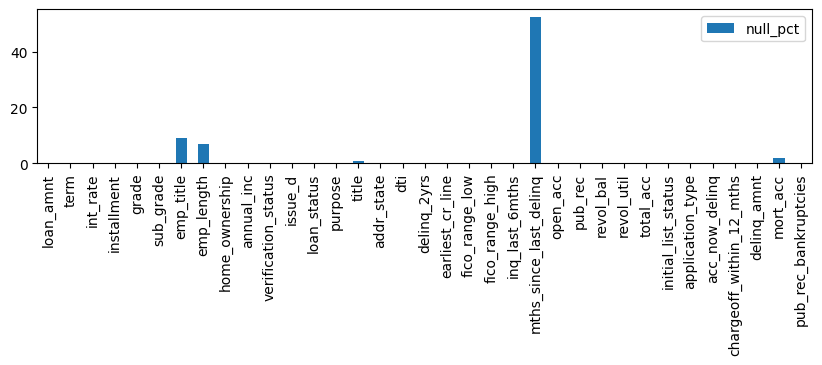

In [6]:
null = pd.DataFrame(data=sample.isnull().sum()/len(sample)*100,columns=['null_pct'])
null = null.loc[null['null_pct']>0]

print('Columns with nulls')
null.plot.bar(figsize=(10,2))

In [7]:
sample.describe()

,loan_amnt,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,mort_acc,pub_rec_bankruptcies
count,878139.000000,878139.000000,8.781370e+05,878139,877200.000000,878132.000000,878132,878139.000000,878139.000000,878131.000000,416965.000000,878132.000000,878132.000000,8.781390e+05,878132.000000,878132.000000,878093.000000,878132.000000,863074.000000,877715.000000
mean,15342.111756,452.057715,7.985634e+04,2017-01-31 09:28:33.250863360,19.283892,0.289518,2000-09-28 18:37:50.758382592,700.494660,704.494865,0.554593,34.953032,11.668499,0.176677,1.694887e+04,24.003808,0.003307,0.007910,9.257599,1.512634,0.122959
min,500.000000,4.930000,0.000000e+00,2007-06-01 00:00:00,0.000000,0.000000,1933-03-01 00:00:00,610.000000,614.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,253.230000,4.700000e+04,2015-09-01 00:00:00,12.080000,0.000000,1996-08-01 00:00:00,675.000000,679.000000,0.000000,17.000000,8.000000,0.000000,5.998000e+03,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13000.000000,381.710000,6.600000e+04,2017-05-01 00:00:00,18.090000,0.000000,2002-02-01 00:00:00,695.000000,699.000000,0.000000,32.000000,11.000000,0.000000,1.149100e+04,22.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,20000.000000,602.810000,9.500000e+04,2018-11-01 00:00:00,24.870000,0.000000,2006-02-01 00:00:00,720.000000,724.000000,1.000000,51.000000,15.000000,0.000000,2.064500e+04,31.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,40000.000000,1719.830000,1.099920e+07,2020-09-01 00:00:00,999.000000,58.000000,2017-07-01 00:00:00,845.000000,850.000000,32.000000,212.000000,87.000000,52.000000,2.358150e+06,173.000000,7.000000,9.000000,138474.000000,87.000000,12.000000
std,9473.836406,272.866711,8.665166e+04,NaN,15.216353,0.845652,NaN,33.741607,33.742488,0.860466,21.880382,5.716762,0.519672,2.275135e+04,12.058351,0.062008,0.102231,595.267950,1.872099,0.353377


### 2 Pre-processing:
<a id='section2'></a>

We filter out loans that are not yet matured and treat "Fully Paid" as 1 and "Charged Off" or "Default" as 0.  
Here, we only consider loans with those two status, as "Current" also has potentially go default in near future.  We also do not consider the loan status of "Does not meet the credit policy". Those are the loans issued at the early stage of the company where the system is not fully developed.

#### 2.1 Data Cleaning
- Only keep matured loans i.e loan status of "Fully Paid  " or "Charged Off"
- Drop emp_title, there are too many categories under this column. 
- Convert employment length column to numeric. i.e 10 years to 10
- Convert int_rate to float
- Convert earliest_cr_line to earliest credit available year

In [8]:
print ('sample size before cleaning: ', len(sample))
print (sample['loan_status'].value_counts(normalize=True))

sample size before cleaning:  878140
loan_status
Fully Paid                                             0.511622
Current                                                0.353038
Charged Off                                            0.123779
Late (31-120 days)                                     0.005456
In Grace Period                                        0.003362
Late (16-30 days)                                      0.000918
Issued                                                 0.000713
Does not meet the credit policy. Status:Fully Paid     0.000675
Does not meet the credit policy. Status:Charged Off    0.000276
Default                                                0.000163
Name: proportion, dtype: float64


In [9]:
def clean_sample(data):
    ''' data cleaning '''
    df = data.copy()
    df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]
    df['fico_score'] =  (df['fico_range_high']+df['fico_range_low'])/2.0
    df['emp_length'] = df['emp_length'].replace('< 1 year','0').str.extract('(\d+)').astype(float)
    df['int_rate']   = df['int_rate'].str.rstrip('%').astype('float') / 100.0
    df['earliest_cr_line'] = df['earliest_cr_line'].dt.year
    df = df.drop(columns=['fico_range_high','fico_range_low','emp_title'])
    return df


loans = clean_sample(sample)

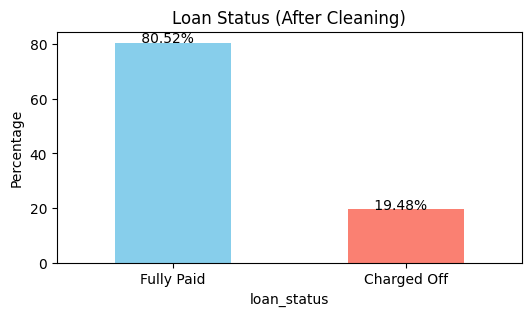

In [10]:
def loan_status_graph(df):
    '''loan status graph''' 
    loan_status = df['loan_status'].value_counts(normalize=True)
    ax = (loan_status*100).plot.bar(figsize=(6,3),color=['skyblue','salmon'])
    for p in ax.patches:
        ax.annotate('      '+str(p.get_height().round(2))+'%', (p.get_x(), p.get_height()))
    
    plt.xticks(rotation=0)
    plt.title('Loan Status (After Cleaning)')
    plt.ylabel('Percentage')    
    
loan_status_graph(loans)

### 3 EDA
<a id='section3'></a>

#### What could affect the default rate ? 
    - Amount borrowed or the monthly installment?
    - Debt to income ratio 
    - Grades and fico credit score (A > B > C > D > E > F)
    - Loan terms: Longer terms can increase default risk
    - How is income affecting default rate ? 
    - Has default rate increased/decreased over time ? 
    - Number of chargeoff had within the last 12 months ? 
    - Number of inquries has attempted ? 
    ... More


#### 3.1 Correlation Heat Map
df.corr() compute pairwise correlation of numerical columns. The default output is the Pearson correlation coefficient. 

**Heat Map**

In the correlation heat map below the red hues implies a positive correlation, whereas blue hues indicate a negative correlation. Borrowers with elevated credit scores, higher annual income, and extended work experience demonstrate a higher likelihood of repaying loans. Conversely, there is a negative correlation with borrowed amounts, debt-to-income ratios, the number of inquiries in the last 6 months, and accounts currently delinquent. 


INFO - - - - - - - - Multicollinearity Exists  - - - - - - - 


,loan_amnt,installment
loan_amnt,NaN,0.951572
installment,0.951572,NaN


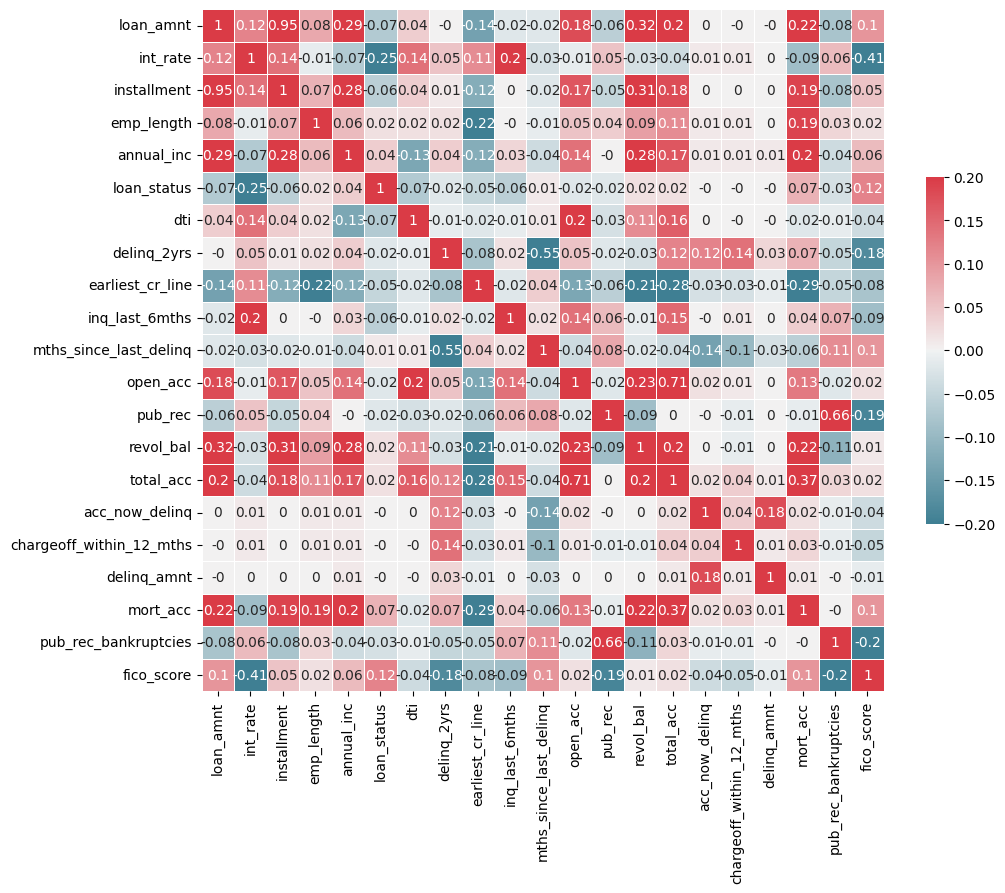

In [11]:
def corr_heatmap(data):
    df = data.copy()
    col = list(df)
    col[0], col[1] = col[1], col[0] #swap column orders
    df['loan_status'] = df['loan_status'].map(dict({'Fully Paid':1, 'Charged Off':0}))
    corr = df[col].corr(numeric_only=True)
    err = corr[(corr>0.8)&(corr<1)].dropna(how="all").dropna(axis="columns",how="all")
    if len(err)>0:
        logger.info('Multicollinearity Exists')
        display (err)
        
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr.round(2), cmap=cmap, vmax=0.2, vmin=-0.2, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
corr_heatmap(loans)

#### 3.2 Loan amount and installment

Analyzing the box plot reveals that defaulted loans exhibit a higher loan amount or installment in average compared to fully paid ones. Hence, it can be inferred that defaults are more prevalent in cases involving larger loan amounts.

**Multicollinearity Issues**

Notice there is a strong correlation between loan_amnt and installment (r>0.9). In general, if the correlation coefficient is above 0.8, we need to drop one of them. It actually make sense because the relationship of monthly installment and loan amount is like the mortgage payment and the principal.

INFO - - - - - - - - Section - Loan amount and monthly installment  - - - - - - - 


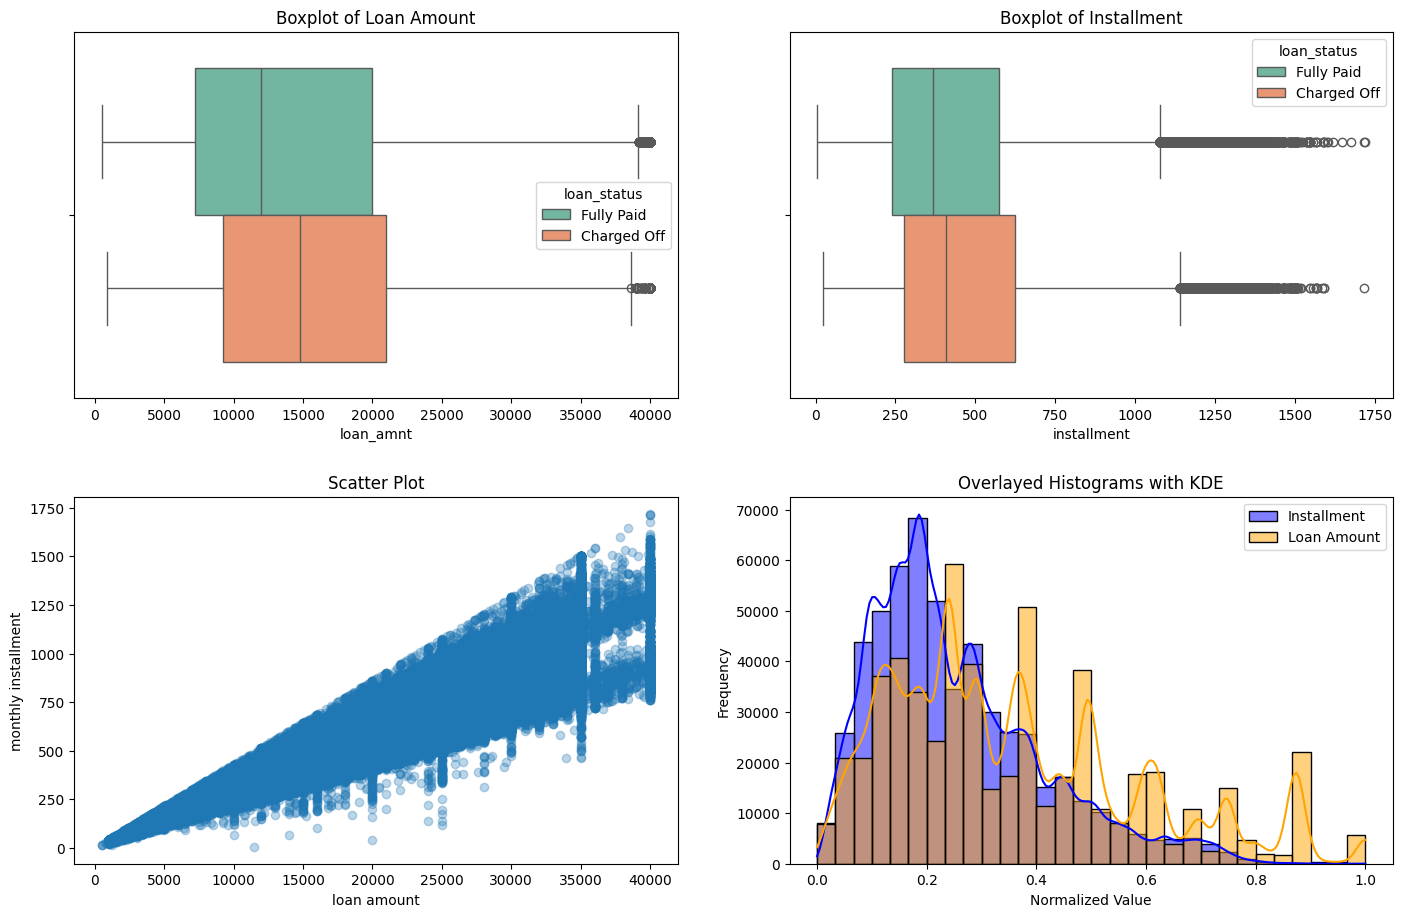

In [12]:
from sklearn import preprocessing

def analysis_on_loan_amnt(df):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.tight_layout(pad=5.0)
    
    # boxplot
    sns.boxplot(data=df[['loan_amnt','loan_status']], x='loan_amnt',hue='loan_status', orient="h", palette="Set2", ax=axes[0,0])
    axes[0,0].set_title('Boxplot of Loan Amount')    
    
    sns.boxplot(data=df[['installment','loan_status']], x='installment',hue='loan_status', orient="h", palette="Set2", ax=axes[0,1])
    axes[0,1].set_title('Boxplot of Installment')
    
    
    ####  Normalization    ######
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(df[['loan_amnt','installment']].values)
    scaled_df = pd.DataFrame(x_scaled,columns=['loan_amnt','installment'])
    u, v = scaled_df['loan_amnt'], scaled_df['installment']
    
    # Scatter Plot
    axes[1, 0].scatter(df['loan_amnt'], df['installment'], alpha=0.3)
    axes[1, 0].set_title('Scatter Plot')
    axes[1, 0].set_xlabel('loan amount')
    axes[1, 0].set_ylabel('monthly installment')
    
    # Overlayed Histograms
    sns.histplot(v, kde=True, label='Installment', color='blue',bins=30, ax=axes[1,1])
    sns.histplot(u, kde=True, label='Loan Amount', color='orange', bins=30,ax=axes[1,1])
    axes[1, 1].set_title('Overlayed Histograms with KDE')
    axes[1,1].set_xlabel('Normalized Value')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend(loc="upper right")

    plt.show()

    
logger.info('Section - Loan amount and monthly installment')    
analysis_on_loan_amnt(loans)

feature importance later ? 

#### 3.3 Grades and Sub-grades
- **Grade**: A, B, C, D, E, F, G: These represent different risk categories or credit grades assigned to loans, with A being the lowest risk and G being the highest risk. Below the bar charts shows the loan performance within each grade. For instance, Grade A has a relatively low number of charged-off loans compared to fully paid loans, indicating better performance and lower risk. Class A, B, C loans count for almost 75% of total sample. The default rate for grade class A, B, C, D, E, F is 6%, 14%, 22%, 30%, 38%, 44%, 50%. Conservative investors probably should avoid E, F, G loans as they often do not pay back. 

- **Subgrade**: Within each grade, there are five subgrades. For instance, within class A, there are subgrades A1, A2, A3, A4, and A5, where a lower numerical value indicates a lower risk level. Generally, the observed default rate aligns with the subgrade trend – A1 exhibits a lower default rate than A2, and so on, up to A5. However, in the realm of higher-risk loans, the accuracy of subgrade classification diminishes. Notably, a sub grade in G shows lower default rate than F. Despite the limited instances of F and G grades, the subgrade data may not sufficiently represent the default patterns in these classes. 


INFO - - - - - - - - Section - Grade and Sub-grade  - - - - - - - 


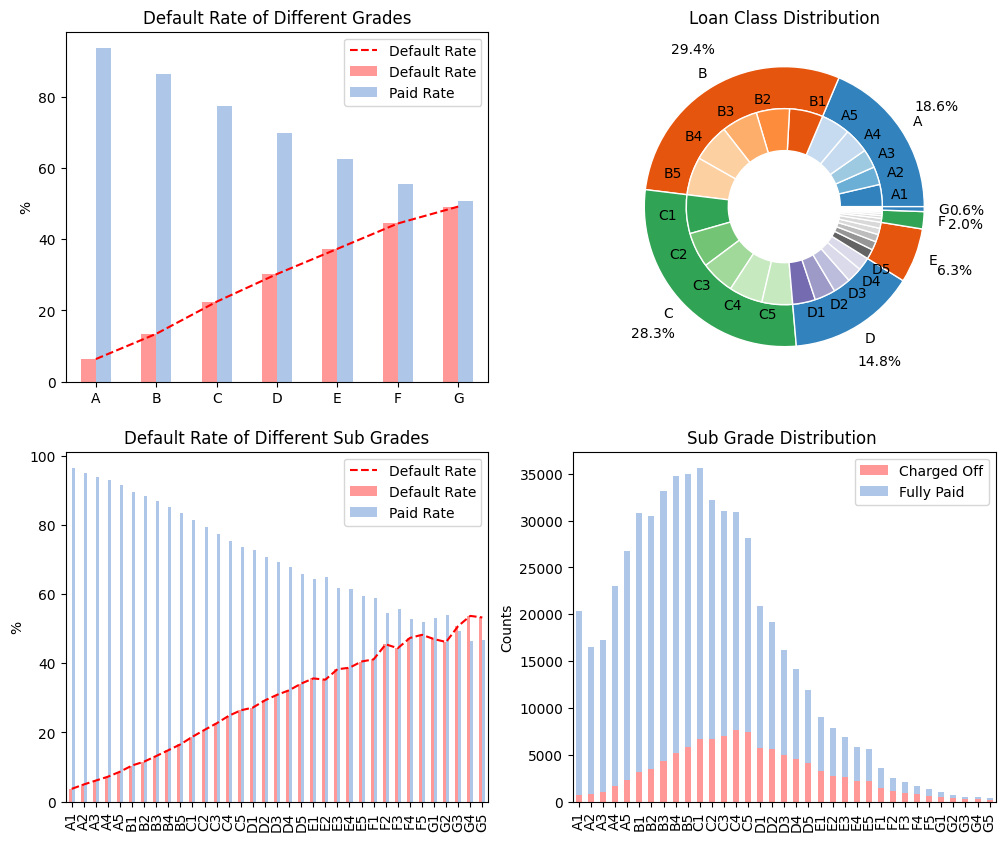

In [24]:

def analysis_on_grade(data):
    df = data[['loan_status','term','grade','sub_grade','int_rate']].copy()

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # -------    Grade    ----------
    status = convert_to_default_rate(df,'grade')
    status['Count'] = status[['Charged Off','Fully Paid']].sum(axis=1)
    status['Paid Rate'] = 100-status['Default Rate']
    status['Count pct'] = 100*status['Count']/len(df)
    status.plot(y='Default Rate',ax=ax[0,0], color='r', linestyle='dashed')
    status[['Default Rate','Paid Rate']].plot.bar(rot=0, ax=ax[0,0], color=cmap([7,1]))    
    ax[0,0].legend(loc='upper right')
    ax[0,0].set_ylabel('%')
    ax[0,0].set_title('Default Rate of Different Loan Grade')
    
    #pie chart: outer ring 
    cm = plt.get_cmap("tab20c")    
    status.plot(
        y     ='Count pct',
        kind  ='pie',
        legend=False,
        autopct=lambda v: f'{v:.1f}%', pctdistance=1.3,
        radius=1, wedgeprops=dict(width=0.3, edgecolor='w'),
        colors=cm(np.arange(3)*4),
        ax=ax[0,1]
    )
    ax[0, 1].set_title('Loan Class Distribution')
    
    # -------   Sub Grade   ----------
    status = convert_to_default_rate(df,'sub_grade')
    status['Count'] = status[['Charged Off','Fully Paid']].sum(axis=1)
    status['Paid Rate']    = 100 - status['Default Rate']
    status['Count pct']    = 100*status['Count']/len(df)
    
    status.plot(y='Default Rate',ax=ax[1,0], color='r', linestyle='dashed')
    status[['Default Rate','Paid Rate']].plot.bar(rot=90, ax=ax[1,0], color=cmap([7,1]))    
    ax[1,0].legend(loc='upper right')
    ax[1,0].set_ylabel('%')
    ax[1,0].set_title('Default Rate of Different Loan Grade')
    
    status.plot.bar(y=['Charged Off', 'Fully Paid'], 
               color=cmap([7,1]),
               rot=90, ax=ax[1,1], stacked=True
              ) 

    #pie chart: inner ring 
    label     = status.index.values
    label = list(label[0:20])+[' ']*(len(label)-20) 
    status.plot(
        y = 'Count pct',
        kind='pie',
        radius=0.7, wedgeprops=dict(width=0.3, edgecolor='w'),
        colors=cm([i//5*4+x for i, x in enumerate(list([0,1,2,3,3])*6)]),
        labels=label, legend=False,
        ax=ax[0,1]
    )
    
    set_ax_param(ax=ax[0,0], title='Default Rate of Different Grades', ylabel='%')
    set_ax_param(ax=ax[1,0], title='Default Rate of Different Sub Grades', ylabel='%')
    set_ax_param(ax=ax[1,1], title='Sub Grade Distribution ', ylabel='Counts')
    ax[0,1].set_ylabel('')
   
    
logger.info('Section - Grade and Sub-grade')    
analysis_on_grade(loans)

#### 3.4 Application Form
- **Application Type**: A significant majority, exceeding 96%, of applications are submitted by individuals, as depicted in the pie chart. Notably, the bar graph suggests a higher likelihood of default for joint applications.

- **Terms**: Analysis of the data reveals that borrowers display a greater inclination to repay loans with a 36-month term compared to a 60-month term. The risk appears to escalate with a more extended loan term.

- **Verification Status**: Interestingly, the verification status seems to have minimal impact on default rates. The difference between source-verified and not verified applications is negligible.

- **Purpose**: Among the various reasons for loan applications, small business emerges as the most likely cause for default, with a rate close to 30%. This aligns with the understanding that financial challenges in a small business can be a precarious sign. Following closely are purposes related to buying a house and moving, each with an average default rate of 25%. In contrast, the least likely purpose to result in default is weddings, with the lowest rate at 11-13%. However, it's crucial to note that these purposes collectively represent less than 1% of the total. The most prevalent use of loans is for debt consolidation, chosen by over half of the applicants, with a default rate of 20%.

INFO - - - - - - - - sample size:  557970  ,  Applicantion  - - - - - - - 


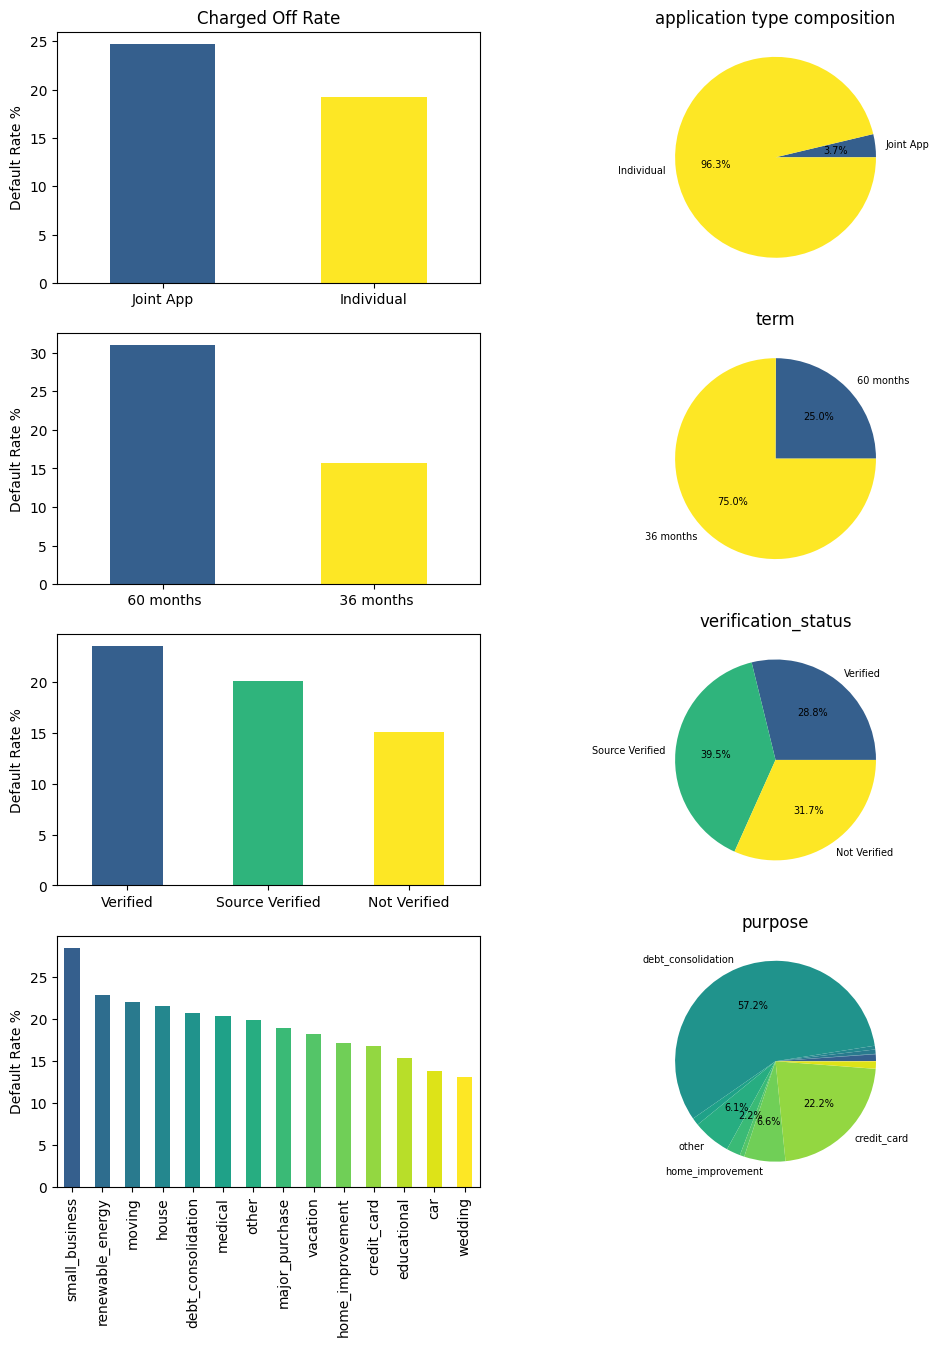

In [25]:
def analysis_on_application(data):
    cols = ['application_type','term','verification_status','purpose']
    df = data[['loan_status']+cols].copy()
    gp = convert_to_default_rate(df,cols).T
    
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))

    cmap = plt.colormaps["viridis"]
    
    for idx, col in enumerate(cols):
        status = gp[list(df[col].unique())].T
        status['Count'] = status['Fully Paid'] + status['Charged Off']
        status['Count pct'] = 100*status['Count']/len(df)
        status = status.sort_values(by='Default Rate', ascending=False)   #sort
        status['Label'] = status.index

        if len(status.index)>5:
            status['Label'] = status.apply(lambda x: x.name if x['Count pct'] >5 else ' ', axis=1)
            
        status.plot(
            kind='pie', 
            y   ='Count',
            autopct=lambda v: f'{v:.1f}%' if v>2 else '', 
            labels=status['Label'],
            legend=False,
            ax=ax[idx,1],
            colors=cmap(np.linspace(0.3, 1, status['Charged Off'].nunique())),
            fontsize=7)
        status.plot.bar(y='Default Rate',
                        color=cmap(np.linspace(0.3, 1, status['Charged Off'].nunique())),
                                            legend=False, 
                                            ax=ax[idx,0], 
                                            rot=0) 

        ax[idx,0].set_ylabel('Default Rate %')        
        set_ax_param(ax=ax[idx,1], title=col, ylabel=' ', loc=None)
        
    ax[0,1].set_title('application type composition')
    ax[0,0].set_title('Charged Off Rate')
    ax[3,0].tick_params(axis='x', rotation=90)
    return

logger.info('sample size:  %d  ,  %s'%(len(loans), 'Applicantion' ))
analysis_on_application(loans)

#### 4. Applicants Information : , mortgage_acc 
- **Home ownership**: Approximately 50% of applicants possess a mortgage, and this group demonstrates the lowest default rate compared to other status such as "rent" and "own". Althoug the default rate is notably high for applicants with an "other" home ownership status, it's crucial to note that only <10 people chose this category in the 18000+ samples. The limited sample size restricts drawing definitive conclusions about this particular category.
- **Mortgage Accounts**:  
- **Employment Length**: Overall default rate decrease slightly as employment length increases. However it is a warning sign if applicants left it blank (null), groups with null have a much higher risk than those who filled in the employment length.
- **Earliest Credit Line**  The earliest credit line availble found in applicants is 1933, more than 90 years ago from today. Mojority of the earliest credit availble year falls between 1980s to 2020. The default rate against credit history year plot shows a U shape implying people with more than 40 years of credit or less than 10 years are much unlikely pay back their loans. Overall, people with shorter credit history are more 
- *****


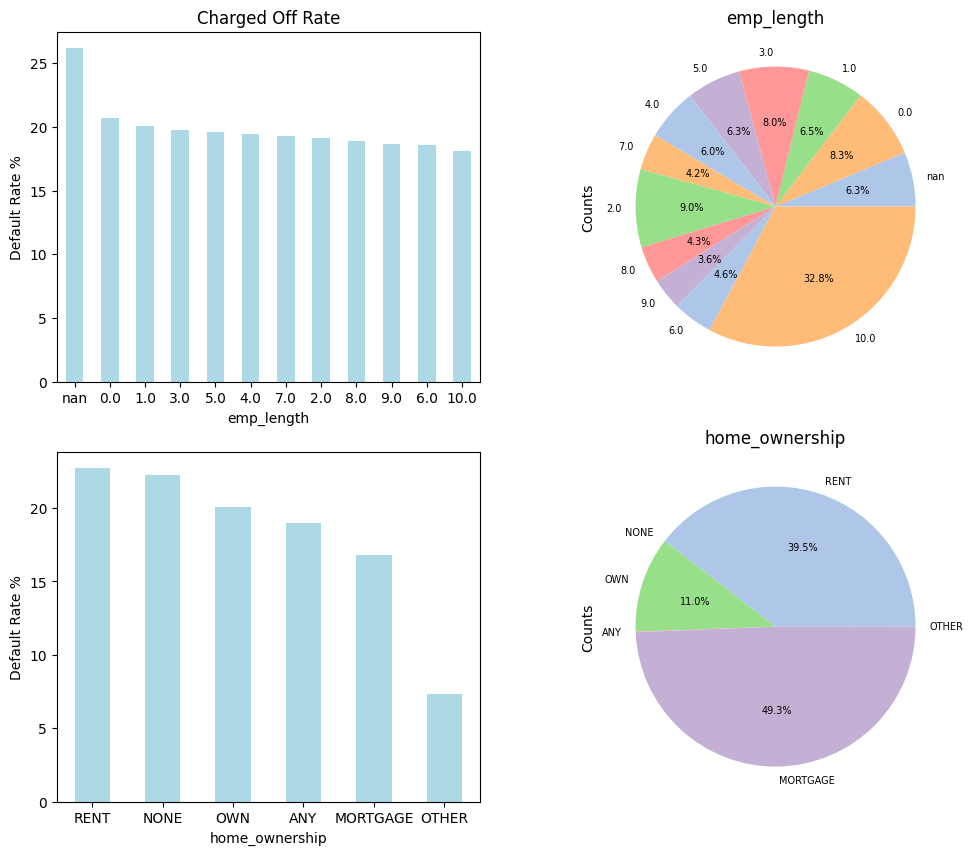

In [29]:
def analysis_on_applicants(data):
    cols = ['emp_length','home_ownership',]
    df = data[['loan_status']+cols].copy()

    gp = convert_to_default_rate(df,cols).T
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    for idx, col in enumerate(cols):
        table = gp[list(df[col].unique())].T
        table['Counts'] = table['Fully Paid']+table['Charged Off']
        table = table.sort_values(by='Default Rate', ascending=False)   #sort
        label = table.index.values
#         display(table)

        table['Counts'].plot(kind='pie', 
                         autopct=lambda v: f'{v:.1f}%' if v>2 else '', 
                         labels=label, 
                         ax=ax[idx,1],
                         colors=cmap(range(1,10,2)),
                         fontsize=7
                        ) # pie chart
        
        table.plot.bar(y='Default Rate',color=['lightblue'], 
                                            legend=False, 
                                            ax=ax[idx,0], 
                                            rot=0)  # bar graph
        ax[idx,1].set_title(col)
        set_ax_param(ax=ax[idx,0], ylabel='Default Rate %', xlabel=col, loc=None)        
    ax[0,0].set_title('Charged Off Rate')
    
    

    
    
def analysis_on_applicants_numerical(data):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    
    df = data[['loan_status','earliest_cr_line', 'issue_d']].copy()
    df['issue_d'] = df['issue_d'].dt.year
    
#     gp = convert_default_rate(df)
    gp = convert_to_default_rate(df,cols).T

    gp = gp.loc[gp['Charged Off']+gp['Fully Paid']>10]


    gp.plot.bar(y=['Charged Off','Fully Paid'], ax=ax[0,0])
    ax[0,0].xaxis.set_major_locator(plt.MaxNLocator(15))
    ax[0,0].set_title('earliest_credit_year')
    ax[0,0].set_ylabel('counts')
    ax[0,0].legend(loc='upper left') 

    gp.plot(y='Default Rate', style=".", ax=ax[1,0])
    ax[1,0].set_ylabel('default rate %')
    ax[1,0].get_legend().remove()
    ax[1,0].legend(loc='upper left')
    
    sns.boxplot(data=df, x='earliest_cr_line',hue='loan_status', orient="h", palette="Set2", ax=ax[2,0])
    sns.boxplot(data=df, x='issue_d',hue='loan_status', orient="h", palette="Set2", ax=ax[1,1])

 

    
    
#     gp = df.set_index('loan_status')[['issue_d']].stack(dropna=False
#                                           ).groupby('loan_status', dropna=False
#                                           ).value_counts(dropna=False
#                                           ).unstack(fill_value=0).T
#     gp['Default Rate'] = gp['Charged Off']/gp.sum(axis=1)*100
#     gp = gp.loc[gp['Charged Off']+gp['Fully Paid']>10]

    return

analysis_on_applicants(loans)
# analysis_on_applicants_numerical(loans)

In [ ]:
ccc = ['loan_amnt', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'loan_status', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal','acc_now_delinq', 'delinq_amnt', 'mort_acc', 'pub_rec_bankruptcies', 'fico_score']
loans.loc[loans['earliest_cr_line']<1975,ccc].groupby(by='loan_status').head(3)

In [ ]:
# def by_issue_time():
#     df = default_rate_by(df_loan,by=['issue_d'])
#     df = df.sort_values(by=['issue_d']).fillna(0)
#     print ('data started :', df.index.min(),'    end :',df.index.max())

#     sns.scatterplot(data=df, x="issue_d", y="Default Rate %").set_title('default rate')
#     df = df.loc[(df.index>='2009-07-01')&(df.index<='2019-03-01')] #loan maturity 3-5 years
#     sns.scatterplot(data=df, x="issue_d", y="Default Rate %").set_title('default rate')
#     plt.legend(labels=["whole period","effective period"])

# #     return df
# by_issue_time()
loans['earliest_cr_line'].min()

In [ ]:
# loans.head(1).T
ccc = [ 'loan_status', 'acc_now_delinq', 'addr_state', 'annual_inc',  'chargeoff_within_12_mths', 'delinq_2yrs', 'delinq_amnt', 'dti', 'earliest_cr_line', 'initial_list_status', 'inq_last_6mths',  'int_rate', 'issue_d', 'mort_acc', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'title', 'total_acc','fico_score']

def foo(df):
    df = df[['loan_status','earliest_cr_line', 'issue_d']].copy()
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format="%b-%Y")
    df['earliest_cr_year'] = df['earliest_cr_line'].dt.year
#     df['earliest_cr_months'] = df['earliest_cr_line'].apply(lambda d: ((last_date.year-d.year)*12+(last_date.month-d.month))//12)
    gp = df.set_index('loan_status')[['earliest_cr_year']].stack(dropna=False
                                          ).groupby('loan_status', dropna=False
                                          ).value_counts(dropna=False
                                          ).unstack(fill_value=0).T
    
    gp[0:10].plot.bar(y='Charged Off')
    print(gp[0:10])
#                )
#     plt.xticks(ticks=range(len(gp.index)), )

#     display(gp.T)

    
    
    
foo(loans)




#### 2.2 Factors 
    What factors may affect default rate ? 
    - 2). Default rate at different grade
    - 
Because we set charged off as 1, the positive correlation means the loan more likely to go default. From the correlation map below, we see that borrowers with delinq history, public records, bankcrupt history, high debt to income ratio (dti),higher bankcard utilization rate more likely to go default. Higher loan amount, multiple inqury attempts in 6 months will also increase the risk. Whereas borrowers with higher income, higher fico score, more credit cards in use tend to pay off the debt. 



#### 3 Modelling 
- 3.1 train-test split 
- Random Forest
- Logistic regression 




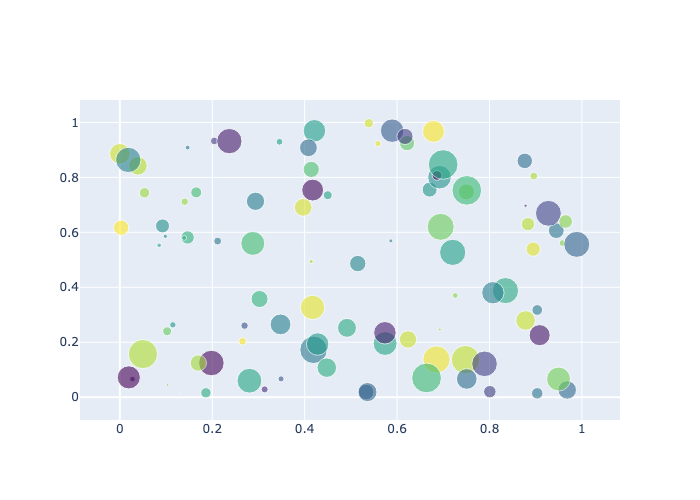

In [38]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N) * 30

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=go.scatter.Marker(
        size=sz,
        color=colors,
        opacity=0.6,
        colorscale="Viridis"
    )
))

fig.show("png")

In [ ]:
import plotly.express as px
fig = px.scatter(px.data.iris(), x="sepal_width", y="sepal_length", color="species")
fig.show("png")

In [34]:
#classification
def default_rate_by(data, by='grade'):
    df = data.groupby([by,'loan_status']).agg({'count':'count'})
    df = pd.pivot_table(df, values='count', index=[by],columns=['loan_status'])
    df['Default Rate %'] = df[1]/df.sum(axis=1)*100
    return df.round(2)
default_rate_by(df_loan,by='grade')

NameError: name 'df_loan' is not defined

reference: https://cs229.stanford.edu/proj2018/report/69.pdf    

In [ ]:
fig, ax = plt.subplots()
size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

display(vals.sum(axis=1))


ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()
